In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import sys; sys.path.insert(1, 'scripts')
from wildlifeml.utils.io import (
    load_csv, 
    load_json, 
    load_pickle,
)

import results_functions as rf

2022-12-02 17:19:04.263107: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
repo_dir = '/home/charrakho/projects/wildlife-experiments'
image_data_dir = '/common/bothmannl/wildlife_images/usecase2/original_images/'
print_metrics = ['acc', 'prec', 'rec', 'f1']
thresholds_dict = {'ours': 0.1, 'progressive': 0.5, 'norouzzadeh': 0.9}

In [3]:
cfg = load_json(os.path.join(repo_dir, 'configs/cfg.json'))

label_map = load_json(
    os.path.join(cfg['data_dir'], 'label_map.json')
)

labels = list(label_map.keys())

empty_map = {}
for k, v in label_map.items():
    if k == 'empty':
        empty_map[k] = 'empty'
    else:
        empty_map[k] = 'non_empty'

label_dict = {k: v for k, v in load_csv(os.path.join(cfg['data_dir'], cfg['label_file']))}

detector_dict = load_json(
    os.path.join(cfg['data_dir'], cfg['detector_file'])
)

dataset_ins = load_pickle(os.path.join(cfg['data_dir'], 'dataset_is_test.pkl'))
dataset_oos = load_pickle(os.path.join(cfg['data_dir'], 'dataset_oos_test.pkl'))

df_meta = pd.read_csv(os.path.join(cfg['data_dir'], 'metadata.csv'))
df_meta = df_meta.rename(columns={'orig_name':'img_name'})
df_ins = df_meta[df_meta['station_set']=='s1'].reset_index(drop=True)
df_oos = df_meta[df_meta['station_set']=='s2'].reset_index(drop=True)

# Global

In [4]:
# Relative frequencies of classes in ins & oos & all datasets
df = pd.DataFrame(index=labels)
df['ins'] = rf.get_frequencies(df_ins, label_map, normalize=True)
df['oos'] = rf.get_frequencies(df_oos, label_map, normalize=True)
df['all'] = rf.get_frequencies(df_meta, label_map, normalize=True)
df = df.T
df

,empty,european_hare,others,red_deer,red_fox,red_squirrel,roe_deer,wild_boar
ins,0.641292,0.019903,0.038616,0.001067,0.029054,0.012188,0.249261,0.008618
oos,0.601061,0.010738,0.044256,0.005685,0.004464,0.000547,0.295183,0.038066
all,0.621436,0.015379,0.041400,0.003346,0.016917,0.006443,0.271926,0.023152


In [5]:
# Number of Stations and Images in ins & oos & all datasets
stations_ins = df_ins['station'].unique()
stations_oos = df_oos['station'].unique()
stations_all = df_meta['station'].unique()
df['n_stations'] = [len(stations_ins), len(stations_oos), len(stations_all)]
df['n_images'] = [len(df_ins), len(df_oos), len(df_meta)]

df

,empty,european_hare,others,red_deer,red_fox,red_squirrel,roe_deer,wild_boar,n_stations,n_images
ins,0.641292,0.019903,0.038616,0.001067,0.029054,0.012188,0.249261,0.008618,18,24368
oos,0.601061,0.010738,0.044256,0.005685,0.004464,0.000547,0.295183,0.038066,19,23748
all,0.621436,0.015379,0.041400,0.003346,0.016917,0.006443,0.271926,0.023152,37,48116


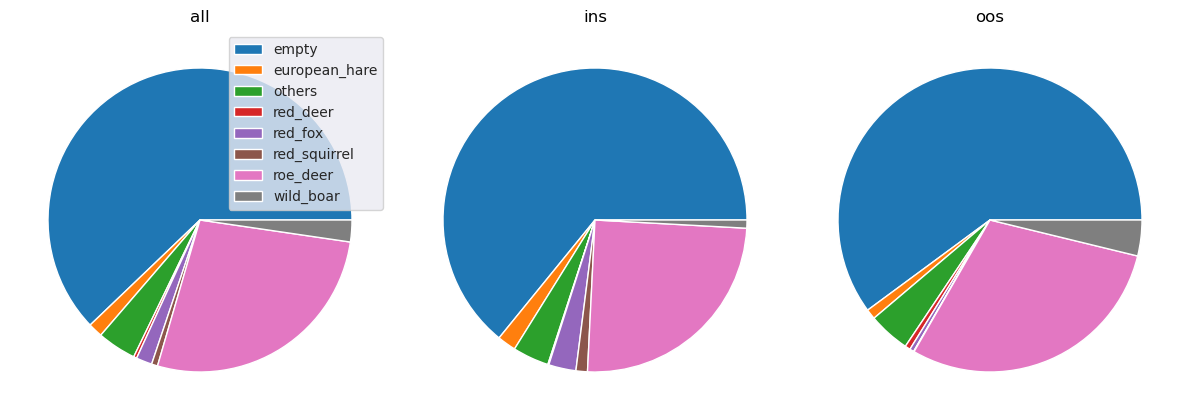

In [6]:
fig, ax = plt.subplots(1,3, sharey=True, figsize=(12,5),  tight_layout=True)

for i, (title, df) in enumerate(zip(['all', 'ins', 'oos'], [df_meta, df_ins, df_oos])):
    rf.plot_frequencies(
        df=df, 
        label_map=label_map, 
        ax=ax[i],
    )
    ax[i].set_title(title)
ax[0].legend(labels, loc="best", fontsize=10)
plt.show()
plt.close()

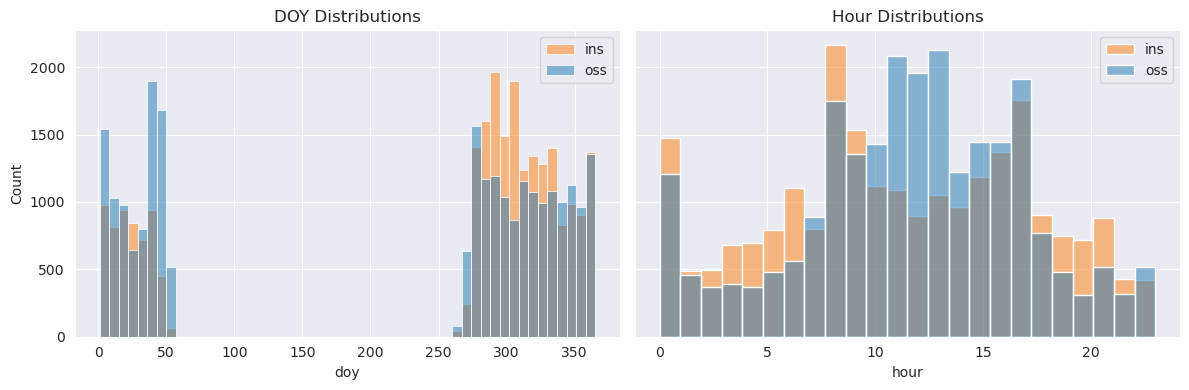

In [7]:
fig, ax = plt.subplots(1,2, figsize=(12,4), sharey=True, tight_layout=True)
sns.histplot(data=df_meta, x='doy', hue='station_set', hue_order=['s1', 's2'], ax=ax[0], bins=52)
ax[0].legend(['ins', 'oss'], loc="best", fontsize=10)
ax[0].set_title('DOY Distributions')

sns.histplot(data=df_meta, x='hour', hue='station_set', hue_order=['s1', 's2'], ax=ax[1], bins=24)
ax[1].legend(['ins', 'oss'], loc="best", fontsize=10)
ax[1].set_title('Hour Distributions')
plt.show()

# IN-SAMPLE

In [8]:
eval_details_path = 'results/202211251613_details_insample_perf.pkl'
eval_details_dict = load_pickle(eval_details_path)

df_pred = rf.build_df_pred(eval_details_dict, label_dict, detector_dict, image_data_dir)
df_pred = rf.labelize_df_pred(df_pred, label_map)
df_pred = pd.merge(df_pred, df_meta, on=['img_name', 'true_class'], how='inner')
df_pred_ins = df_pred.copy()

conf_md = rf.get_binary_confusion_md(
    dataset=dataset_ins, 
    threshold=thresholds_dict['ours'], 
    repo_dir=repo_dir,
)
conf_ppl = rf.get_binary_confusion_ppl(
    y_true=df_pred['true_class'].map(empty_map), 
    y_pred=df_pred['pred_class'].map(empty_map), 
)
pref_b = rf.evaluate_performance(
    y_true=df_pred['true_class'].map(empty_map), 
    y_pred=df_pred['pred_class'].map(empty_map), 
    labels=['non_empty', 'empty'], 
    average=None,
)
pref_m = rf.evaluate_performance(
    y_true=df_pred['true_class'], 
    y_pred=df_pred['pred_class'], 
    labels=labels, 
    average='macro',
)

results_ins = {
    'tnr_md': conf_md.get('tnr'),
    'tpr_md': conf_md.get('tpr'),
    'fnr_md': conf_md.get('fnr'),
    'fpr_md': conf_md.get('fpr'),
    'tnr_ppl': conf_ppl.get('tnr'),
    'tpr_ppl': conf_ppl.get('tpr'),
    'fnr_ppl': conf_ppl.get('fnr'),
    'fpr_ppl': conf_ppl.get('fpr'),
    'acc_b': pref_b.get('acc'),
    'prec_b': pref_b.get('prec')[0],
    'rec_b': pref_b.get('rec')[0],
    'f1_b': pref_b.get('f1')[0],
    'acc_m': pref_m.get('acc'),
    'prec_m': pref_m.get('prec'),
    'rec_m': pref_m.get('rec'),
    'f1_m': pref_m.get('f1'),
}
results_ins

{'tnr_md': 0.8522146507666098,
 'tpr_md': 0.944954128440367,
 'fnr_md': 0.05504587155963303,
 'fpr_md': 0.14778534923339012,
 'tnr_ppl': 0.8962536023054755,
 'tpr_ppl': 0.9635922330097088,
 'fnr_ppl': 0.03640776699029126,
 'fpr_ppl': 0.1037463976945245,
 'acc_b': 0.948831332912192,
 'prec_b': 0.9706601466992665,
 'rec_b': 0.9635922330097088,
 'f1_b': 0.9671132764920828,
 'acc_m': 0.8843967150979154,
 'prec_m': 0.869295009617693,
 'rec_m': 0.7694201742279487,
 'f1_m': 0.812167083286727}

               precision    recall  f1-score   support

        empty       0.87      0.90      0.88       347
european_hare       0.84      0.78      0.81        65
       others       0.61      0.59      0.60       112
     red_deer       1.00      0.67      0.80         3
      red_fox       0.90      0.77      0.83        95
 red_squirrel       0.91      0.81      0.86        48
     roe_deer       0.92      0.95      0.93       884
    wild_boar       0.91      0.69      0.78        29

     accuracy                           0.88      1583
    macro avg       0.87      0.77      0.81      1583
 weighted avg       0.88      0.88      0.88      1583



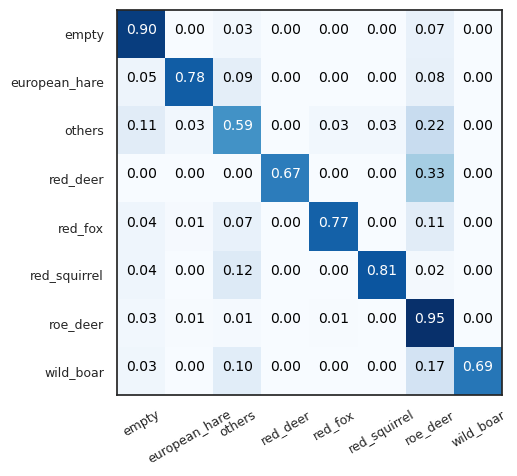

In [9]:
#_paper_
# Table: confusion matrix and recall/precision
report = classification_report(
    y_true=df_pred['true_class'], 
    y_pred=df_pred['pred_class'], 
    labels=labels,
    zero_division=0,
    output_dict=False,
)
print(report)

rf.inspect_confusion(
    df_pred=df_pred, 
    normalize=True, 
    labels=labels, 
    ax=None,
)

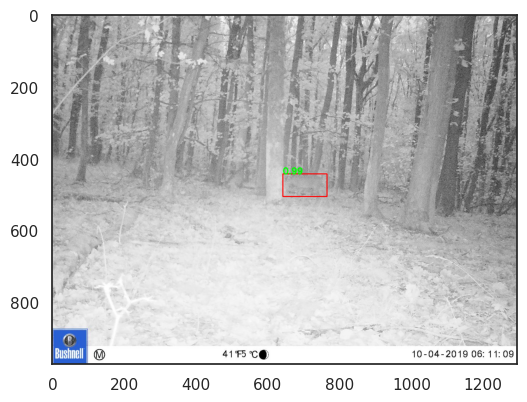

img_name: 17687_10040017.JPG
true_class: roe_deer
pred_class: red_fox
pred_score: 0.455
n_preds: 1
pred_classes: ['red_fox']
pred_confs: [0.459]
md_confs: [0.99]
score_dict: {'red_fox': 0.455, 'empty': 0.288, 'european_hare': 0.16, 'others': 0.058, 'roe_deer': 0.031, 'red_deer': 0.0, 'red_squirrel': 0.0, 'wild_boar': 0.0}


In [10]:
#_paper_

# Perhaps show some missclassified images
rf.inspect_misclasses(
    df_pred=df_pred, 
    test_label='roe_deer', 
    label_map=label_map,
    n_displays=1, 
    is_truth=True,
    sorting='random',
)


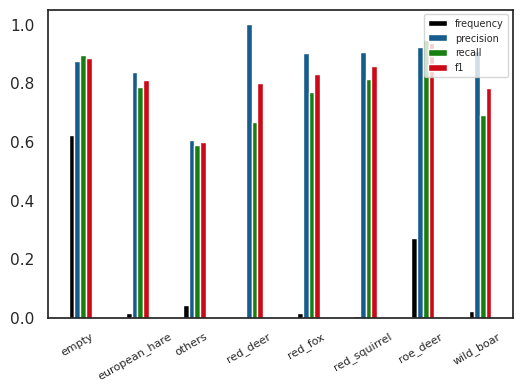

In [11]:
rf.plot_class_performance(
    df_pred=df_pred, 
    df_meta=df_meta, 
    label_map=label_map, 
    ax=None)

# EMPTY VS NON-EMPTY

In [12]:
#_paper_
#Table: rates for 3 different thresholds: 

eval_details_path = 'results/202211251652_details_insample_empty.pkl'
eval_details_dict = load_pickle(eval_details_path)

thresholds = list(thresholds_dict.values())
names = list(thresholds_dict.keys())

df = pd.DataFrame()
df_pred_list = []

for index_tresh, threshold in enumerate(thresholds):
    
    df_pred = rf.build_df_pred(eval_details_dict[threshold], label_dict, detector_dict, image_data_dir)
    df_pred = rf.labelize_df_pred(df_pred, label_map)
    df_pred = pd.merge(df_pred, df_meta, on=['img_name', 'true_class'], how='inner')
    df_pred_list.append(df_pred)
    
    conf_md = rf.get_binary_confusion_md(
        dataset=dataset_ins, 
        threshold=threshold, 
        repo_dir=repo_dir,
    )
    conf_ppl = rf.get_binary_confusion_ppl(
        y_true=df_pred['true_class'].map(empty_map), 
        y_pred=df_pred['pred_class'].map(empty_map),
    )
    pref_b = rf.evaluate_performance(
        y_true=df_pred['true_class'].map(empty_map), 
        y_pred=df_pred['pred_class'].map(empty_map), 
        labels=['non_empty', 'empty'], 
        average=None,
    )
    pref_m = rf.evaluate_performance(
        y_true=df_pred['true_class'], 
        y_pred=df_pred['pred_class'], 
        labels=labels, 
        average='macro',
    )
    results = {
        'tnr_md': conf_md.get('tnr'),
        'tpr_md': conf_md.get('tpr'),
        'fnr_md': conf_md.get('fnr'),
        'fpr_md': conf_md.get('fpr'),
        'tnr_ppl': conf_ppl.get('tnr'),
        'tpr_ppl': conf_ppl.get('tpr'),
        'fnr_ppl': conf_ppl.get('fnr'),
        'fpr_ppl': conf_ppl.get('fpr'),
        'acc_b': pref_b.get('acc'),
        'prec_b': pref_b.get('prec')[0],
        'rec_b': pref_b.get('rec')[0],
        'f1_b': pref_b.get('f1')[0],
        'acc_m': pref_m.get('acc'),
        'prec_m': pref_m.get('prec'),
        'rec_m': pref_m.get('rec'),
        'f1_m': pref_m.get('f1'),
    }
    df_x = pd.DataFrame(data=list(results.values()), index=results.keys())
    df = pd.concat([df, df_x.T], axis=0)

df['names'] = names
df = df.set_index('names')
df


,tnr_md,tpr_md,fnr_md,fpr_md,tnr_ppl,tpr_ppl,fnr_ppl,fpr_ppl,acc_b,prec_b,rec_b,f1_b,acc_m,prec_m,rec_m,f1_m
names,,,,,,,,,,,,,,,,
ours,0.852215,0.944954,0.055046,0.147785,0.806916,0.983010,0.016990,0.193084,0.944409,0.947738,0.983010,0.965052,0.876816,0.873429,0.755143,0.805069
progressive,0.933586,0.837129,0.162871,0.066414,0.907781,0.966828,0.033172,0.092219,0.953885,0.973920,0.966828,0.970361,0.899558,0.880515,0.807944,0.836943
norouzzadeh,0.963276,0.801221,0.198779,0.036724,0.927954,0.940129,0.059871,0.072046,0.937461,0.978939,0.940129,0.959142,0.869867,0.699279,0.676959,0.686165


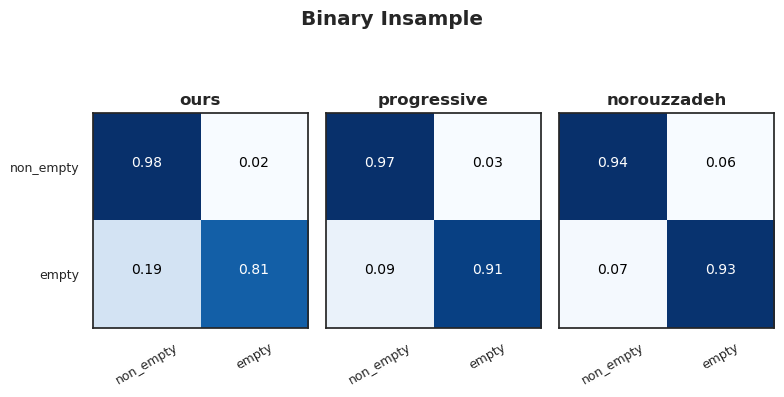

In [13]:
fig, axes = plt.subplots(1,3, figsize=(8, 4), tight_layout=True, sharey=True)

for index_tresh, threshold in enumerate(thresholds):
    ax = axes[index_tresh]
    df_pred = df_pred_list[index_tresh].copy()
    df_pred['true_class'] = df_pred['true_class'].map(empty_map)
    df_pred['pred_class'] = df_pred['pred_class'].map(empty_map)
    rf.inspect_confusion(
        df_pred=df_pred, 
        normalize=True, 
        labels=['non_empty', 'empty'], 
        ax=ax)
    ax.set_title(names[index_tresh], weight='bold')

plt.suptitle("Binary Insample", weight='bold')
plt.show()
plt.close()

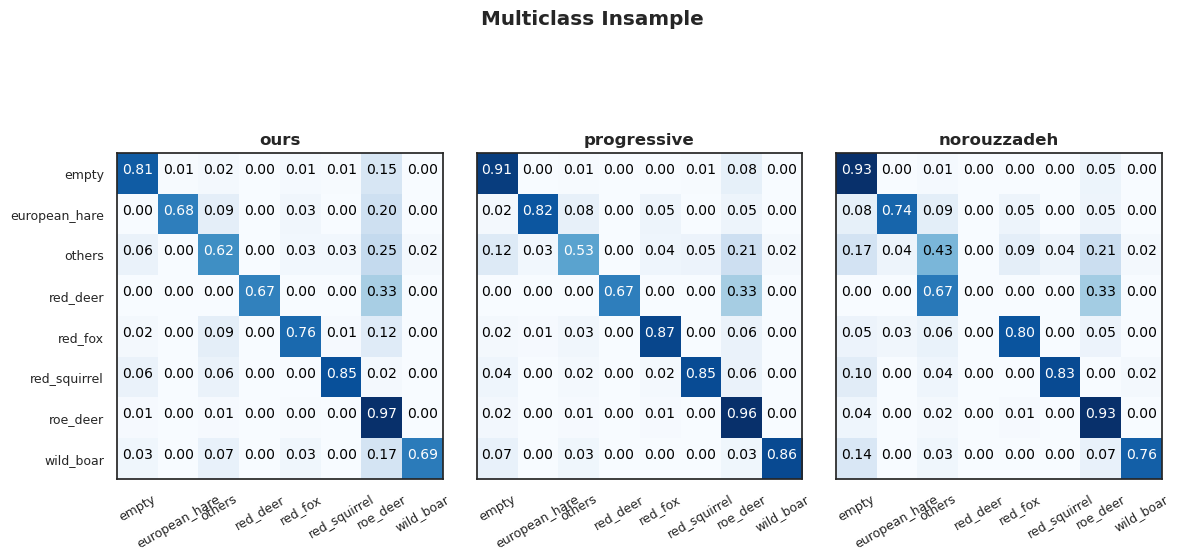

In [14]:
fig, axes = plt.subplots(1,3, figsize=(12, 6), tight_layout=True, sharey=True)

for index_tresh, threshold in enumerate(thresholds):
    ax = axes[index_tresh] 
    rf.inspect_confusion(
        df_pred=df_pred_list[index_tresh], 
        normalize=True, 
        labels=labels, 
        ax=ax)
    ax.set_title(names[index_tresh], weight='bold')
    
plt.suptitle("Multiclass Insample", weight='bold')
plt.show()
plt.close()

In [15]:
#_paper_
#XX% of empty images are correctly detected (TN) 
#only XX% are falsely labeled as empty where in fact they contain animals (FN)
TN = df.loc['ours', 'tnr_ppl'] 
FN = df.loc['ours', 'fnr_ppl']
print(f'{TN:.3}% of empty images are correctly detected')
print(f'{FN:.3}% are falsely labeled as empty')

0.807% of empty images are correctly detected
0.017% are falsely labeled as empty


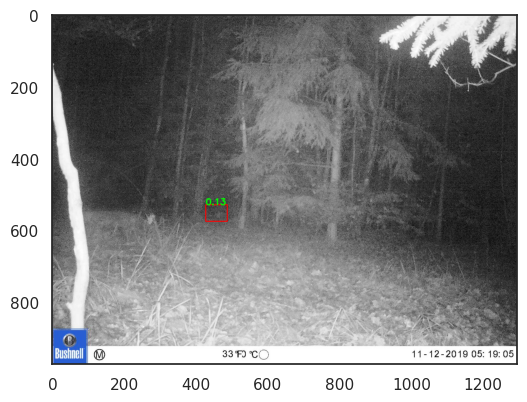

img_name: 46645_11120079.JPG
true_class: non_empty
pred_class: empty
pred_score: 0.128
n_preds: 1
pred_classes: ['empty']
pred_confs: [1.0]
md_confs: [0.13]
score_dict: {'empty': 0.128, 'european_hare': 0.0, 'others': 0.0, 'red_deer': 0.0, 'red_fox': 0.0, 'red_squirrel': 0.0, 'roe_deer': 0.0, 'wild_boar': 0.0}


In [16]:
#_paper_
#Figure: some false non-empties
rf.inspect_misclasses(
    df_pred=df_pred, 
    test_label='empty', 
    label_map=label_map,
    n_displays=1, 
    is_truth=False,
    sorting='descending',
)

# OUT-OF-SAMPLE

In [17]:
eval_details_path = 'results/202211251804_details_oosample_perf.pkl'
eval_details_dict = load_pickle(eval_details_path)

df_pred = rf.build_df_pred(eval_details_dict, label_dict, detector_dict, image_data_dir)
df_pred = rf.labelize_df_pred(df_pred, label_map)
df_pred = pd.merge(df_pred, df_meta, on=['img_name', 'true_class'], how='inner')
df_pred_oos = df_pred.copy()

conf_md = rf.get_binary_confusion_md(
    dataset=dataset_oos, 
    threshold=thresholds_dict['ours'], 
    repo_dir=repo_dir,
)
conf_ppl = rf.get_binary_confusion_ppl(
    y_true=df_pred['true_class'], 
    y_pred=df_pred['pred_class'],
)
pref_b = rf.evaluate_performance(
    y_true=df_pred['true_class'].map(empty_map), 
    y_pred=df_pred['pred_class'].map(empty_map), 
    labels=['non_empty', 'empty'], 
    average=None,
)
pref_m = rf.evaluate_performance(
    y_true=df_pred['true_class'], 
    y_pred=df_pred['pred_class'], 
    labels=labels, 
    average='macro',
)
results_oos = {
    'tnr_md': conf_md.get('tnr'),
    'tpr_md': conf_md.get('tpr'),
    'fnr_md': conf_md.get('fnr'),
    'fpr_md': conf_md.get('fpr'),
    'tnr_ppl': conf_ppl.get('tnr'),
    'tpr_ppl': conf_ppl.get('tpr'),
    'fnr_ppl': conf_ppl.get('fnr'),
    'fpr_ppl': conf_ppl.get('fpr'),
    'acc_b': pref_b.get('acc'),
    'prec_b': pref_b.get('prec')[0],
    'rec_b': pref_b.get('rec')[0],
    'f1_b': pref_b.get('f1')[0],
    'acc_m': pref_m.get('acc'),
    'prec_m': pref_m.get('prec'),
    'rec_m': pref_m.get('rec'),
    'f1_m': pref_m.get('f1'),
}

               precision    recall  f1-score   support

        empty       0.84      0.62      0.71       320
european_hare       0.66      0.56      0.61        41
       others       0.32      0.39      0.35       104
     red_deer       0.00      0.00      0.00        21
      red_fox       0.35      0.46      0.40        13
 red_squirrel       0.25      0.75      0.38         4
     roe_deer       0.83      0.91      0.87      1040
    wild_boar       0.84      0.67      0.75       123

     accuracy                           0.78      1666
    macro avg       0.51      0.55      0.51      1666
 weighted avg       0.78      0.78      0.78      1666



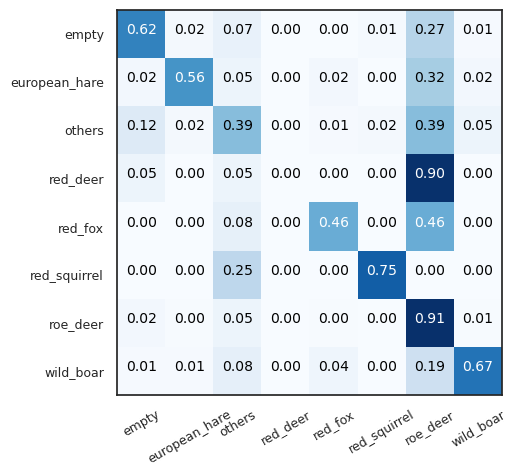

In [18]:
#_paper_

# Table: OOS performance 
report = classification_report(
    y_true=df_pred['true_class'], 
    y_pred=df_pred['pred_class'], 
    labels=labels,
    zero_division=0,
    output_dict=False,
)
print(report)

rf.inspect_confusion(
    df_pred=df_pred, 
    normalize=True, 
    labels=labels, 
    ax=None,
)

In [19]:
#_paper_
# Table: compare INS va. OOS (macro averages)

df = pd.DataFrame(index=list(results_ins.keys()))
df['ins']= results_ins.values()
df['oos']= results_oos.values()
df

,ins,oos
tnr_md,0.852215,0.849483
tpr_md,0.944954,0.936674
fnr_md,0.055046,0.063326
fpr_md,0.147785,0.150517
tnr_ppl,0.896254,0.621875
tpr_ppl,0.963592,0.971025
fnr_ppl,0.036408,0.028975
fpr_ppl,0.103746,0.378125
acc_b,0.948831,0.903962
prec_b,0.970660,0.915266


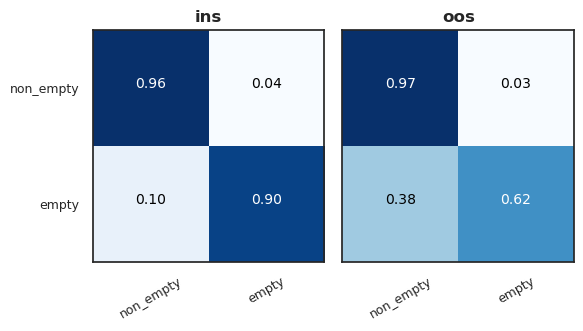

In [20]:
df_pred_ins_b = df_pred_ins.copy()
df_pred_ins_b['true_class'] = df_pred_ins_b['true_class'].map(empty_map)
df_pred_ins_b['pred_class'] = df_pred_ins_b['pred_class'].map(empty_map)

df_pred_oos_b = df_pred_oos.copy()
df_pred_oos_b['true_class'] = df_pred_oos_b['true_class'].map(empty_map)
df_pred_oos_b['pred_class'] = df_pred_oos_b['pred_class'].map(empty_map)


fig, ax = plt.subplots(1, 2, figsize=(6, 4), tight_layout=True, sharey=True)
rf.inspect_confusion(
    df_pred=df_pred_ins_b, 
    normalize=True, 
    labels=['non_empty', 'empty'], 
    ax=ax[0])
ax[0].set_title('ins', weight='bold')

rf.inspect_confusion(
    df_pred=df_pred_oos_b, 
    normalize=True, 
    labels=['non_empty', 'empty'], 
    ax=ax[1])
ax[1].set_title('oos', weight='bold')
plt.show()
plt.close()

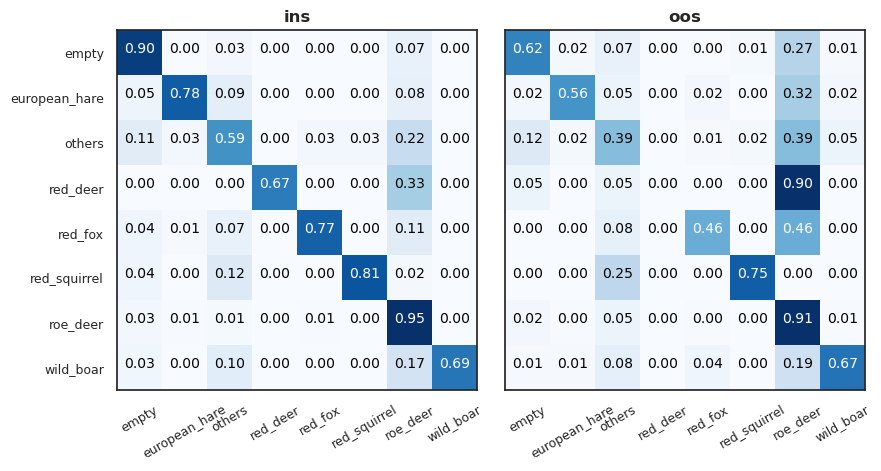

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(9, 6), tight_layout=True, sharey=True)
rf.inspect_confusion(
    df_pred=df_pred_ins, 
    normalize=True, 
    labels=labels, 
    ax=ax[0])
ax[0].set_title('ins', weight='bold')

rf.inspect_confusion(
    df_pred=df_pred_oos, 
    normalize=True, 
    labels=labels, 
    ax=ax[1])
ax[1].set_title('oos', weight='bold')
plt.show()
plt.close()